In [1]:
import sys
import re
import numpy as np
import pandas as pd
import seaborn as sns
import liwc
from matplotlib import pyplot as plt

from collections import defaultdict, Counter


sys.path.append('/home/kalkiek/projects/reddit-political-affiliation/')

from src.features.collect_samples import get_non_political_samples, get_political_samples, get_bad_actor_samples
from src.features.collect_user_features import read_in_non_pol_user_features, read_in_pol_user_features, read_in_bad_actor_features
from src.features.political_affiliations.conglomerate_affiliations import get_all_political_users
from src.features.bad_actors.bad_actors import read_in_bad_actor_usernames
from src.models.ppr.build_graph import grab_bot_accounts

### Read in the sample submissions from each group 

In [2]:
non_pol_df = get_non_political_samples()
pol_df = get_political_samples()
bad_actors_df = get_bad_actor_samples()

print(len(non_pol_df))
print(len(pol_df))
print(len(bad_actors_df))

24990
24968
23301


### Data Cleaning

We changed filter criteria after collecting some of this data so confirm the data is clean

Double check no bots 

In [3]:
bots = grab_bot_accounts()
bots.add('[deleted]')
print("Removing known bots just in case...")
non_pol_df = non_pol_df[~non_pol_df['username'].isin(bots)]
pol_df = pol_df[~pol_df['username'].isin(bots)]
bad_actors_df = bad_actors_df[~bad_actors_df['username'].isin(bots)]

# # We changed filter criteria after collecting some of this data
# # Verify the political users and bad actors are up to date
# pol_users = get_all_political_users()
# bad_actors = get_bad_actors_90_days_1_flip_flop()

# pol_df = pol_df[pol_df['username'].isin(pol_users)]
# bad_actors_df = bad_actors_df[bad_actors_df['username'].isin(bad_actors)]

print(len(non_pol_df))
print(len(pol_df))
print(len(bad_actors_df))

Known bots: 393
Removing known bots just in case...
24990
9822
23301


In [26]:
N = 5000

def random_df_sample(df, n):
    df_shuffled = df.sample(frac=1).reset_index(drop=True)
    return df_shuffled.iloc[:n]
    
print("Grabbing random 10k sample from each data source")
pol_sample = random_df_sample(pol_df, N)
non_pol_sample = random_df_sample(non_pol_df, N)
bad_actor_sample = random_df_sample(bad_actors_df, N)

pol_sample.head()

Grabbing random 10k sample from each data source


,username,subreddit,created,text
0,Whisper,science,1170305102,"sorry for the double reply, but what what you ..."
1,eromitlab,nsfw,1283299439,pull over and hit that like a boss.\n
2,runujhkj,CFB,1385856034,holy shit i want state to play usm again so ba...
3,banthisaltplz,OutOfTheLoop,1533081607,i'm reading this as a lot of revisionism as we...
4,FalmerbloodElixir,Games,1391212849,&gt;when-hell-freezes-over scenario: nintendo ...


In [27]:
parse, category_names = liwc.load_token_parser('/shared/0/resources/liwc/LIWC2015_English.dic')


def tokenize(text):
    for match in re.finditer(r'\w+', text, re.UNICODE):
        yield match.group(0)
        

def compute_category_percentages_for_all_users(df, source):
    username_category_totals = defaultdict(lambda: defaultdict(int))

    for index, row in df.iterrows():
        sample = list(tokenize(row['text']))
        for token in tokenize(row['text']):
            for category in parse(token):
                username_category_totals[row['username']][category] += 1

    username_category_percentages = defaultdict(lambda: defaultdict(float))

    for user, category_counts in username_category_totals.items():
        total_words = np.sum(list(category_counts.values()))
        for category, count in category_counts.items():
            username_category_percentages[user][category] = count / total_words
    
    rows = []
    for user, category_percentages in username_category_percentages.items():
        for category, percentage in category_percentages.items():
            row = {'username': user, 'source': source, 'category': category, 'percentage': percentage}
            rows.append(row)
    return pd.DataFrame(rows)

pol_cat_per_df = compute_category_percentages_for_all_users(pol_df, 'Political')  
non_pol_cat_per_df = compute_category_percentages_for_all_users(non_pol_df, 'Non-Political')   
bad_actor_cat_per_df = compute_category_percentages_for_all_users(bad_actors_df, 'Bad Actors')   

pol_cat_per_df.head()

,username,source,category,percentage
0,e40,Political,function (Function Words),0.192287
1,e40,Political,adverb (Adverbs),0.021184
2,e40,Political,auxverb (Auxiliary Verbs),0.028246
3,e40,Political,verb (Verbs),0.055133
4,e40,Political,focuspresent (Present Focus),0.038294


In [28]:
pol_avg_per = pol_cat_per_df.groupby(['category', 'source']).mean().reset_index().sort_values('percentage', ascending=False)
non_pol_avg_per = non_pol_cat_per_df.groupby(['category', 'source']).mean().reset_index().sort_values('percentage', ascending=False)
bad_actor_avg_per = bad_actor_cat_per_df.groupby(['category', 'source']).mean().reset_index().sort_values('percentage', ascending=False)

print("Top 10 categories for political users")
print(pol_avg_per.head(10))

print("Top 10 categories for non-political users")
print(non_pol_avg_per.head(10))

print("Top 10 categories for bad actors")
print(bad_actor_avg_per.head(10))

frames = [pol_avg_per, non_pol_avg_per, bad_actor_avg_per]

df_avg_per = pd.concat(frames)
df_avg_per.head()

Top 10 categories for political users
                         category     source  percentage
29      function (Function Words)  Political    0.183805
53             pronoun (Pronouns)  Political    0.060324
69                   verb (Verbs)  Political    0.057717
14  cogproc (Cognitive Processes)  Political    0.054006
55           relativ (Relativity)  Political    0.051997
52            prep (Prepositions)  Political    0.049188
63                social (Social)  Political    0.043674
27   focuspresent (Present Focus)  Political    0.043174
51      ppron (Personal Pronouns)  Political    0.039303
3                 affect (Affect)  Political    0.036563
Top 10 categories for non-political users
                         category         source  percentage
29      function (Function Words)  Non-Political    0.184851
53             pronoun (Pronouns)  Non-Political    0.062452
69                   verb (Verbs)  Non-Political    0.059885
55           relativ (Relativity)  Non-Political 

,category,source,percentage
29,function (Function Words),Political,0.183805
53,pronoun (Pronouns),Political,0.060324
69,verb (Verbs),Political,0.057717
14,cogproc (Cognitive Processes),Political,0.054006
55,relativ (Relativity),Political,0.051997


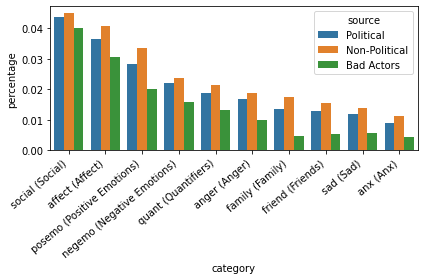

In [32]:
categories = category_names[20:30]
df_avg = df_avg_per[df_avg_per['category'].isin(categories)]

ax = sns.barplot(x="category", y="percentage", hue="source", data=df_avg)

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

In [27]:
pol_words = " ".join(pol_sample['text'].tolist())
non_pol_words = " ".join(non_pol_sample['text'].tolist())
bad_actor_words = " ".join(bad_actor_sample['text'].tolist())

print("Number of political words: {}".format(len(pol_words.split(" "))))
print("Number of non-political words: {}".format(len(non_pol_words.split(" "))))
print("Number of bad actor words: {}".format(len(bad_actor_words.split(" "))))

Number of political words: 350244
Number of non-political words: 653752
Number of bad actor words: 1059178


# LIWC Category Analysis

In [28]:
parse, category_names = liwc.load_token_parser('/shared/0/resources/liwc/LIWC2015_English.dic')

def tokenize(text):
    for match in re.finditer(r'\w+', text, re.UNICODE):
        yield match.group(0)
        
pol_counts = Counter(category for token in pol_words for category in parse(token))
non_pol_counts = Counter(category for token in non_pol_words for category in parse(token))
bad_actor_counts = Counter(category for token in bad_actor_words for category in parse(token))

## Categories as Percentages

In [29]:
def compute_category_percentages(category_counts, source):
    rows = []
    total_words = np.sum(list(category_counts.values()))
    for category, count in category_counts.items():
        entry = {'Category': category, 'Percentage': count / total_words, 'Source': source}
        rows.append(entry)
    return rows

rows = []
rows.extend(compute_category_percentages(pol_counts, 'Political'))
rows.extend(compute_category_percentages(non_pol_counts, 'Non-Political'))
rows.extend(compute_category_percentages(bad_actor_counts, 'Bad Actors'))

categories_df = pd.DataFrame(rows, columns=['Category', 'Percentage', 'Source'])
categories_df.head()

,Category,Percentage,Source
0,function (Function Words),0.188760,Political
1,article (Articles),0.080392,Political
2,informal (Informal Language),0.197660,Political
3,netspeak (Netspeak),0.197660,Political
4,assent (Assent),0.010425,Political


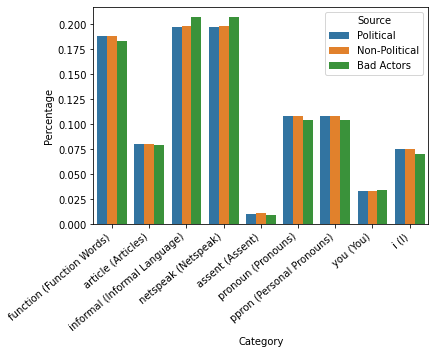

In [32]:
ax = sns.barplot(x="Category", y="Percentage", hue="Source", data=categories_df)

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
# plt.tight_layout()
plt.show()

### Bootstrap Confidence Intervals

In [49]:
n_iters = 100
sample_size = 5000 

p_bootstrap_samples, np_bootstrap_samples, ba_bootstrap_samples = [], [], []

rows = []

for i in range(n_iters):
    
    pol_sample = random_df_sample(pol_df, n=sample_size)
    pol_sample_words = " ".join(pol_sample['text'].tolist())
    pol_sample_counts = Counter(category for token in pol_sample_words for category in parse(token))
    total_pol_sample_words = np.sum(list(pol_sample_counts.values()))
    
    non_pol_sample = random_df_sample(non_pol_df, n=sample_size)
    non_pol_sample_words = " ".join(non_pol_sample['text'].tolist())
    non_pol_sample_counts = Counter(category for token in non_pol_sample_words for category in parse(token))
    total_non_pol_sample_words = np.sum(list(non_pol_sample_counts.values()))
    
    bad_actors_sample = random_df_sample(bad_actors_df, n=sample_size)
    bad_actors_sample_words = " ".join(bad_actors_sample['text'].tolist())
    bad_actors_sample_counts = Counter(category for token in bad_actors_sample_words for category in parse(token))
    total_bad_actors_sample_words = np.sum(list(bad_actors_sample_counts.values()))
    
    rows.extend(compute_category_percentages(total_pol_sample_words, pol_sample_counts, 'Political'))
    rows.extend(compute_category_percentages(total_non_pol_sample_words, non_pol_sample_counts, 'Non-Political'))
    rows.extend(compute_category_percentages(total_bad_actors_sample_words, bad_actors_sample_counts, 'Bad Actors'))
    
    
bs_categories_df = pd.DataFrame(rows, columns=['Category', 'Percentage', 'Source'])
bs_categories_df.head()

,Category,Percentage,Source
0,informal (Informal Language),0.198387,Political
1,netspeak (Netspeak),0.198387,Political
2,function (Function Words),0.187876,Political
3,pronoun (Pronouns),0.108545,Political
4,ppron (Personal Pronouns),0.108545,Political


In [50]:
combined_df = pd.concat([categories_df, bs_categories_df], ignore_index=True)
combined_df.head(15)

,Category,Percentage,Source
0,function (Function Words),0.188133,Political
1,pronoun (Pronouns),0.108209,Political
2,ppron (Personal Pronouns),0.108209,Political
3,you (You),0.032741,Political
4,informal (Informal Language),0.198442,Political
5,netspeak (Netspeak),0.198442,Political
6,article (Articles),0.079925,Political
7,assent (Assent),0.010432,Political
8,i (I),0.075468,Political
9,function (Function Words),0.188172,Non-Political


In [51]:
print(len(combined_df))

2727


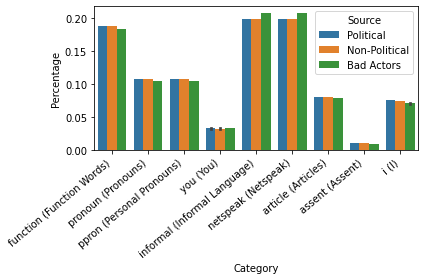

In [53]:
ax = sns.barplot(x="Category", y="Percentage", hue="Source", data=combined_df)

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

# LDA On Sample Submissions

# Log Odds Visualization?